In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from stable_baselines3 import SAC

from compute_spectral_efficiency import compute_se_np
from env import CFmMIMOEnv
from simulation_para import L, K, tau_p, min_power, max_power, initial_power, square_length, decorr, sigma_sf, \
    noise_variance_dbm, delta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
AP_locations = torch.rand(L, dtype=torch.complex64, device=device) * square_length
UE_initial_locations = torch.rand(K, dtype=torch.complex64, device=device) * square_length

In [3]:
SI_ENV = CFmMIMOEnv(L=L, K=K, tau_p=tau_p, initial_power=initial_power, min_power=min_power, max_power=max_power,
                    APs_positions=AP_locations, UEs_positions=UE_initial_locations, square_length=square_length,
                    decorr=decorr, sigma_sf=sigma_sf, noise_variance_dbm=noise_variance_dbm, delta=delta)

In [4]:
num_of_setups = 100
prelog_factor = 1

In [5]:
SAC_SGD_256_1K = SAC.load("SAC_CFmMIMO_SGD")
SAC_SGD_256_20K = SAC.load("SAC_CFmMIMO_SGD[256 256]")
SAC_SGD_128_20K = SAC.load("SAC_CFmMIMO_SGD[128 256 128]")

In [6]:
cf_signal = np.zeros((K, num_of_setups))
cf_interference = np.zeros((K, K, num_of_setups))
cf_pred_power = np.zeros((K, num_of_setups))

cf_SE_SGD_256_1K = np.zeros((K, num_of_setups))
cf_SE_SGD_256_20K = np.zeros((K, num_of_setups))
cf_SE_SGD_128_20K = np.zeros((K, num_of_setups))

SE_maxmin_cell = np.zeros((K, num_of_setups))
SE_maxprod_cell = np.zeros((K, num_of_setups))
SE_sumrate_cell = np.zeros((K, num_of_setups))


In [7]:
# specify if the SE is calculated with previous SINR terms (lagging) or with the current SINR terms
lagging_SE = True

In [8]:
over_all_time = time.time()

for n in range(num_of_setups):
    obs, info = SI_ENV.reset()

    init_signal = info['init_signal']
    init_interference = info['init_interference']
    init_pilot_index = info['init_pilot_index']
    init_beta_val = info['init_beta_val']

    # DL Agent
    action, _ = SAC_SGD_256_1K.predict(obs, deterministic=True)
    _, info = SI_ENV.calculate(init_signal, init_interference, action, lagging_SE, init_pilot_index, init_beta_val)
    cf_SE_SGD_256_1K[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    action, _ = SAC_SGD_256_20K.predict(obs, deterministic=True)
    _, info = SI_ENV.calculate(init_signal, init_interference, action, lagging_SE, init_pilot_index, init_beta_val)
    cf_SE_SGD_256_20K[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'],
                                            prelog_factor)

    action, _ = SAC_SGD_128_20K.predict(obs, deterministic=True)
    _, info = SI_ENV.calculate(init_signal, init_interference, action, lagging_SE, init_pilot_index, init_beta_val)
    cf_SE_SGD_128_20K[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'],
                                            prelog_factor)

    # native power optimization algorithms
    _, info = SI_ENV.maxmin_algo(init_signal, init_interference, max_power, prelog_factor, lagging_SE, init_pilot_index, init_beta_val)
    SE_maxmin_cell[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    _, info = SI_ENV.maxprod_algo(init_signal, init_interference, max_power, prelog_factor, lagging_SE, init_pilot_index, init_beta_val)
    SE_maxprod_cell[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

    _, info = SI_ENV.maxsumrate_algo(init_signal, init_interference, max_power, prelog_factor, lagging_SE, init_pilot_index, init_beta_val)
    SE_sumrate_cell[:, n] = compute_se_np(info['signal'], info['interference'], info['predicted_power'], prelog_factor)

print('Total inference: ', time.time() - over_all_time)

Total inference:  97.55458903312683


In [9]:
cf_SE_SGD_256_1K_flatten = cf_SE_SGD_256_1K.flatten()
sorted_cf_SE_SGD_256_1K = np.sort(cf_SE_SGD_256_1K_flatten)
cdf_SE_SGD_256_1K_pred = np.linspace(0, 1, len(sorted_cf_SE_SGD_256_1K))

cf_SE_SGD_256_20K_flatten = cf_SE_SGD_256_20K.flatten()
sorted_cf_SE_SGD_256_20K = np.sort(cf_SE_SGD_256_20K_flatten)
cdf_SE_SGD_256_20K_pred = np.linspace(0, 1, len(sorted_cf_SE_SGD_256_20K))

cf_SE_SGD_128_20K_flatten = cf_SE_SGD_128_20K.flatten()
sorted_cf_SE_SGD_128_20K = np.sort(cf_SE_SGD_128_20K_flatten)
cdf_SE_SGD_128_20K_pred = np.linspace(0, 1, len(sorted_cf_SE_SGD_128_20K))

In [10]:
SE_maxmin_flatten = SE_maxmin_cell.flatten()
SE_maxprod_flatten = SE_maxprod_cell.flatten()
SE_sumrate_flatten = SE_sumrate_cell.flatten()

sorted_SE_maxmin = np.sort(SE_maxmin_flatten)
sorted_SE_maxprod = np.sort(SE_maxprod_flatten)
sorted_SE_sumrate = np.sort(SE_sumrate_flatten)

cdf_SE_maxmin = np.linspace(0, 1, len(sorted_SE_maxmin))
cdf_SE_maxprod = np.linspace(0, 1, len(sorted_SE_maxprod))
cdf_SE_sumrate = np.linspace(0, 1, len(sorted_SE_sumrate))

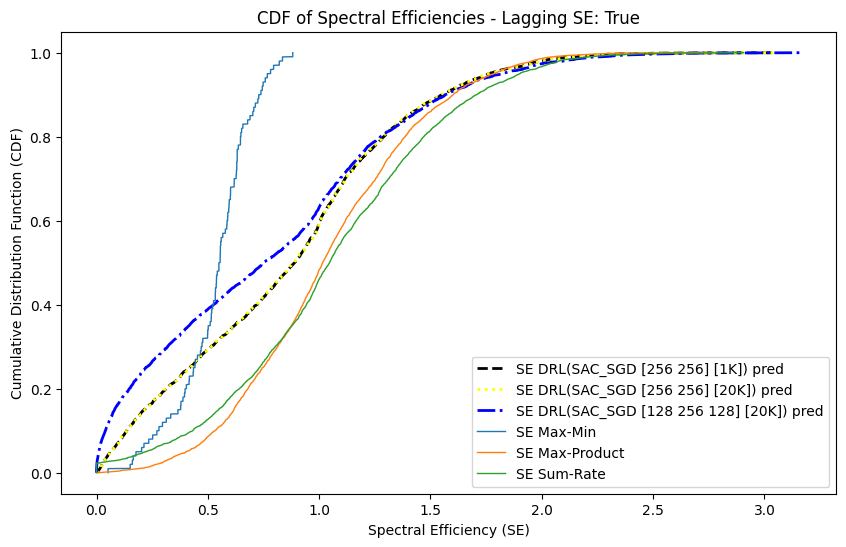

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_cf_SE_SGD_256_1K, cdf_SE_SGD_256_1K_pred, label='SE DRL(SAC_SGD [256 256] [1K]) pred', linewidth=2,
         linestyle='--', color='black')
plt.plot(sorted_cf_SE_SGD_256_20K, cdf_SE_SGD_256_20K_pred, label='SE DRL(SAC_SGD [256 256] [20K]) pred', linewidth=2,
         linestyle=':', color='yellow')
plt.plot(sorted_cf_SE_SGD_128_20K, cdf_SE_SGD_128_20K_pred, label='SE DRL(SAC_SGD [128 256 128] [20K]) pred', linewidth=2,
         linestyle='-.', color='blue')
plt.plot(sorted_SE_maxmin, cdf_SE_maxmin, label='SE Max-Min', linewidth=1)
plt.plot(sorted_SE_maxprod, cdf_SE_maxprod, label='SE Max-Product', linewidth=1)
plt.plot(sorted_SE_sumrate, cdf_SE_sumrate, label='SE Sum-Rate', linewidth=1)

plt.xlabel('Spectral Efficiency (SE)')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title(f'CDF of Spectral Efficiencies - Lagging SE: {lagging_SE}')
plt.legend()